# **Pneumonia identification from X-Ray images**
## Big Data Engineering final project
*Catalina Arnaiz del Pozo and Andrea Escolar Peña*



## **1. Introduction**

Pneumonia is an infection that inflames your lungs' air sacs (alveoli). The air sacs may fill up with fluid or pus, causing symptoms such as a cough, fever, chills and trouble breathing.
There are more than 30 different causes of pneumonia and the main types are:
1. Bacterial pneumonia
2. Viral pneumonia
3. Mycoplasma pneumonia
4. Other

Diagnosis is usually made based on your recent health history (such as surgery, a cold, or travel exposures) and the extent of the illness. Moreover, chest X-rays are commonly used to diagnose this illness. 


### **Dataset description**

The dataset was obtained from Kaggle (https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia) and consists of 3 folders (train, test and validation data), each one divided into 2 folders: normal and pneumonia images giving rise to two classes. Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. 

Therefore, the aim is to create a pySpark-based Neural Network integrating Analytics Zoo and implementing Tensor Flow and Keras to diagnose pneumonia from X-ray images. 

## **2. Environment preparation**

### Installing Analytics Zoo 

Analytics Zoo is an open source Big Data AI platform which includes some features for scaling end-to-end AI to distributed Big Data.

In [ ]:
%%capture
# Install jdk8
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
import os
# Set environment variable JAVA_HOME.
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
!update-alternatives --set java /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java
!java -version

In [ ]:
%%capture
# Install latest pre-release version of Analytics Zoo
# Installing Analytics Zoo from pip will automatically install pyspark, bigdl,
# and their dependencies.
!pip install --pre --upgrade analytics-zoo[ray]
exit() # refresh the pkg you just install

### Preparing Orca context

The Orca library scales out the single node Python notebook across large clusters (so as to process distributed Big Data).

In [ ]:
%%capture
from zoo.orca import OrcaContext
from zoo.orca import init_orca_context, stop_orca_context

# This function allows the users to specify the computing environment for the 
# program and the amount of physical resources to be allocated for the porgram 
# on the underlying cluster.
init_orca_context(cluster_mode="local", cores=1)

## **3. Dataset definition**

#### Retrieving data using the Kaggle API. To re-run the code, the *kaggle.json* file must be uploaded to the upload widget. 

In [ ]:
from google.colab import files

!pip install -U -q kaggle
!mkdir -p ~/.kaggle

# Note: kaggle.json file must be uploaded in the emerging box
files.upload()

!cp kaggle.json ~/.kaggle/

!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

# To make unreadable the Kaggle API 
!chmod 600 /root/.kaggle/kaggle.json'

Saving kaggle.json to kaggle (1).json
chest-xray-pneumonia.zip: Skipping, found more recently modified local copy (use --force to force download)
/bin/bash: -c: line 0: unexpected EOF while looking for matching `''
/bin/bash: -c: line 1: syntax error: unexpected end of file


In [ ]:
%%capture
!unzip /content/chest-xray-pneumonia.zip

### Preparing the data for the analysis

The steps (tutorials) proposed in Keras and Orca were follwed to define the datasets and the model and to train and evaluate the proposed classification model, respectively:

*  Keras: https://keras.io/examples/vision/image_classification_from_scratch/
*   Orca: https://analytics-zoo.readthedocs.io/en/latest/doc/Orca/QuickStart/orca-tf2keras-quickstart.html


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# We needed to create 3 "creator functions" (train, test and val) in order to
# use them later on with Orca. These functions consist on all the steps required
# for the TensorFlow dataset creation, data augmentation and modification. 

def train_data_creator(config, batch_size):

  """This function involves all the steps required for the TensorFlow train 
  dataset creation, data augmentation and modification."""

  # Data augentation is needed because the number of images is very small. 
  # The images were flipped horizontally and sligthly rotated.

  data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
  )

  image_size = (64, 64)
  batch_size = 32
  
  train = tf.keras.preprocessing.image_dataset_from_directory(
      "chest_xray/train",
      seed=1337,
      image_size=image_size,
      batch_size=batch_size,
  )

  train = train.map(lambda x, y: (data_augmentation(x, training=True), y))

  # This transformation was required for later steps involving Orca 
  # (also with test and val)
  train = train.map(lambda x, y: (tf.cast(x, dtype = tf.float32), y))
  
  return train

def test_data_creator(config, batch_size):

  """This function involves all the steps required for the TensorFlow test 
  dataset creation, data augmentation and modification."""

  data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
  )

  image_size = (64, 64)
  batch_size = 32
  
  test = tf.keras.preprocessing.image_dataset_from_directory(
      "chest_xray/test",
      seed=1337,
      image_size=image_size,
      batch_size=batch_size,
  )
  
  test = test.map(
  lambda x, y: (data_augmentation(x, training=True), y))

  test = test.map(lambda x, y: (tf.cast(x, dtype = tf.float32), y))

  return test

def val_data_creator(config, batch_size):
  """This function involves all the steps required for the TensorFlow validation 
  dataset creation, data augmentation and modification."""

  data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
  )
  
  image_size = (64, 64)
  batch_size = 32
  
  val = tf.keras.preprocessing.image_dataset_from_directory(
      "chest_xray/val",
      seed=1337,
      image_size=image_size,
      batch_size=batch_size,
  )
  
  val = val.map(
  lambda x, y: (data_augmentation(x, training=True), y))

  val = val.map(lambda x, y: (tf.cast(x, dtype = tf.float32), y))

  return val

### Data visualization

In order to visualize the data, a variable is needed instead of a function. This is why we needed to repeat the steps, but outside a function.

In [ ]:
image_size = (180, 180)
batch_size = 256

train = tf.keras.preprocessing.image_dataset_from_directory(
    "chest_xray/train",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

test = tf.keras.preprocessing.image_dataset_from_directory(
    "chest_xray/test",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

val = tf.keras.preprocessing.image_dataset_from_directory(
    "chest_xray/val",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 5216 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
Found 16 files belonging to 2 classes.


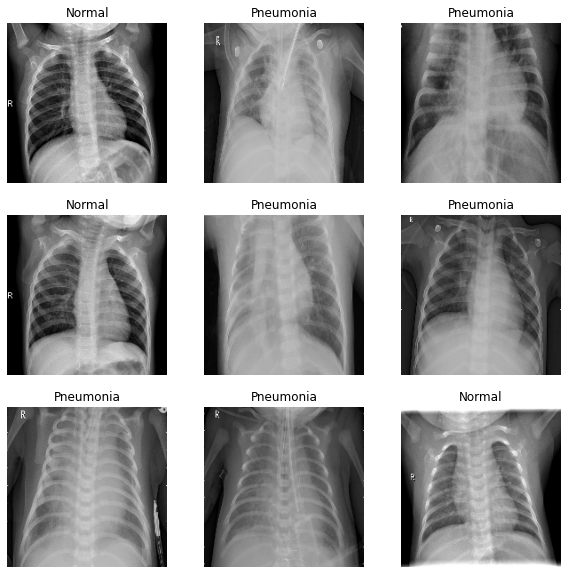

In [ ]:
# We plot the images

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        if labels[i] == 0:
          plt.title("Normal")
        else:
          plt.title("Pneumonia")
        plt.axis("off")

## **4. Model definition**

The model used is VGG16, that "is a simple and widely used Convolutional Neural Network (CNN) Architecture used for ImageNet, a large visual database project used in visual object recognition software research". https://medium.com/@mygreatlearning/what-is-vgg16-introduction-to-vgg16-f2d63849f615. 

![](https://miro.medium.com/max/1400/0*xurYLT8UBpFKPNQA)

In [ ]:
# Model creator function to use it with Orca
def model_creator(config):

  """This function involves the model definition for it to be evaluated
  with Orca"""

  from keras.applications.vgg16 import VGG16
  from keras.applications.imagenet_utils import decode_predictions
  from keras.models import Sequential
  from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
  from keras.models import Model

  base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64,64,3)) 
  
  # Freeze convolutional layers
  for layer in base_model.layers:
      layer.trainable = False    

  # Establish new fully connected block
  x = base_model.output
  x = Flatten()(x)  # flatten from convolution tensor output  
  
  # Number of layers and units are hyperparameters, as usual
  x = Dense(250, activation='relu')(x) 
  x = Dense(100, activation='relu')(x)

  # Since there are only 2 classess, perform binary classification with sigmoid 
  # function
  predictions = Dense(1,activation='sigmoid')(x) 

  # The model we will train
  model = Model(inputs=base_model.input, outputs=predictions)
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 
           keras.metrics.Precision(name='precision'), 
           keras.metrics.Recall(name='recall')])

  return model

## **5. Evaluating by using Orca estimator**

In [ ]:
from zoo.orca.learn.tf2 import Estimator

est = Estimator.from_keras(model_creator=model_creator)

2022-02-11 10:12:56,064	INFO services.py:1174 -- View the Ray dashboard at http://172.28.0.2:8265


{'node_ip_address': '172.28.0.2', 'raylet_ip_address': '172.28.0.2', 'redis_address': '172.28.0.2:6379', 'object_store_address': '/tmp/ray/session_2022-02-11_10-12-55_344833_1562/sockets/plasma_store', 'raylet_socket_name': '/tmp/ray/session_2022-02-11_10-12-55_344833_1562/sockets/raylet', 'webui_url': '172.28.0.2:8265', 'session_dir': '/tmp/ray/session_2022-02-11_10-12-55_344833_1562', 'metrics_export_port': 46308, 'node_id': 'cf7c6ed8e782f9a8893ea7268bdf6d0570bf88f05e43c58e53a96e5b'}


(pid=1872) WARNING:tensorflow:From /usr/local/lib/python3.7/dist-packages/zoo/orca/learn/tf2/tf_runner.py:317: _CollectiveAllReduceStrategyExperimental.__init__ (from tensorflow.python.distribute.collective_all_reduce_strategy) is deprecated and will be removed in a future version.
(pid=1872) Instructions for updating:
(pid=1872) use distribute.MultiWorkerMirroredStrategy instead
(pid=1872) 2022-02-11 10:13:02.402980: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [ ]:
image_size = (64, 64)
batch_size = 32

# Model is fitted by Orca
stats = est.fit(train_data_creator,
                epochs=5,
                batch_size=batch_size,
                validation_data=val_data_creator)

# Model is evaluated with the test set                
stats = est.evaluate(test_data_creator, batch_size=batch_size)
est.shutdown()

In [ ]:
# Metrics are shown
for statistic, value in stats.items():
  print (statistic, ": ", value, sep = "")
stop_orca_context()

validation_loss: 0.70029217004776
validation_accuracy: 0.8060897588729858
validation_precision: 0.7750511169433594
validation_recall: 0.971794843673706


## **6. Conclusion**

The model is very accurate, since it reaches an accuracy percentage of 80%. The precision and recall are also high, and the loss value is small. Taking all this into account, it could be said that the proposed model is appropriate. Moreover, in order to improve the accuracy and performance of the model, other more complex and powerful networks such as ResNet or Inception could be used. 